In [1]:
# Business Understanding

In [2]:
# Question I am trying to answer: "What combination of skills, technologies, and experience levels are most strongly associated with high-salary developer roles in the US?"

# Questions blog post will answer:
# 1) What are the most important features of the data set, what do they mean, and how do they drive the predicted outcome? 
# 2) What unusual, or creative, insights are you able to gather from the data set?
# 3) How accurate is the model that you have trained to predict the data in the data set?
# 4) What will happen in a creative, predictive, scenario using the model that you have trained?

In [3]:
#Data Understanding

In [4]:
import os
from pathlib import Path
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Get current working directory
current_directory = Path(os.getcwd())

# Load raw survey data
raw_data = pd.read_csv(
    current_directory / 'Developer Survey' / 'survey_results_public.zip',
    compression="zip"
)


In [5]:
#Getting General Information
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Columns: 114 entries, ResponseId to JobSat
dtypes: float64(13), int64(1), object(100)
memory usage: 56.9+ MB


In [6]:
#Checking for nulls values
raw_data.isna().sum()

ResponseId                 0
MainBranch                 0
Age                        0
Employment                 0
RemoteWork             10631
                       ...  
JobSatPoints_11        35992
SurveyLength            9255
SurveyEase              9199
ConvertedCompYearly    42002
JobSat                 36311
Length: 114, dtype: int64

In [7]:
#Checking data types
raw_data.dtypes

ResponseId               int64
MainBranch              object
Age                     object
Employment              object
RemoteWork              object
                        ...   
JobSatPoints_11        float64
SurveyLength            object
SurveyEase              object
ConvertedCompYearly    float64
JobSat                 float64
Length: 114, dtype: object

In [8]:
raw_data.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


In [9]:
#Data Exploration Findings
    #- There are many null values that I will need to account for before modeling    
    #- There are many columns with object data types that I will need to account for before modeling
    #- There are some columns that have multiple choice answers that have a ';' delimiter
    #- There are many rows that have null values since different sections of the survey are optional so many respondants partially reply to survey
#Survey Exploration Findings
    #- There were many people surveys that I should exclude based on the business question
    #- There is a question where you answer "Apples" if you are paying attention. All rows withouts apples in that column should be deleted
    #- There are many questions that are unlikely to have a strong relationship with business question (ex: section dedicated to Stack Overflow usage, survey length)

In [10]:
#Data Preparation

In [11]:
#Removing all rows without apples in column "Check"
data_apples = raw_data[raw_data['Check'] == "Apples"]
data_apples.info()

#No rows were removed. Likely these responses were filtered prior to publishing dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65437 entries, 0 to 65436
Columns: 114 entries, ResponseId to JobSat
dtypes: float64(13), int64(1), object(100)
memory usage: 57.4+ MB


In [12]:
# Removing all rows where respondent doesn't use coding professionally or are not currently working

# List of responses that say they currently code in some capacity professionally
pro_dev_responses = [
    'I am a developer by profession',
    'I am not primarily a developer, but I write code sometimes as part of my work/studies'
]

# List of employment status responses to exclude (there are some respondents who picked every option so excluding is better than including)
pro_emp_responses = [
    'Not employed, but looking for work',
    'Not employed, and not looking for work',
    'Student, full-time',
    'Retired',
    'I prefer not to say',
    'Student, part-time'
]

# Filtering data by if they code professionally
pro_data = data_apples.loc[data_apples['MainBranch'].isin(pro_dev_responses)]

# Filtering data by employment status
pro_data_employment = pro_data['Employment'].str.split(';', expand=True)
pro_data_employment_keys = pro_data_employment.keys()
pro_data_employment_mask = ~pro_data_employment[pro_data_employment_keys].isin(pro_emp_responses).any(axis=1)
pro_data = pro_data.loc[pro_data_employment_mask]

pro_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47454 entries, 0 to 65435
Columns: 114 entries, ResponseId to JobSat
dtypes: float64(13), int64(1), object(100)
memory usage: 41.6+ MB


In [13]:
# Verifying that rows were filtered correctly
print(pro_data['MainBranch'].value_counts())

I am a developer by profession                                                           43470
I am not primarily a developer, but I write code sometimes as part of my work/studies     3984
Name: MainBranch, dtype: int64


In [14]:
# Filtering to only respondents that answered the TeamsQuestions portion of the survey
# This is important as there are a few questions that give insight into how long they have had their job, independence, and organizational influence

teams_filtered_data = pro_data.loc[pro_data['TBranch'] == 'Yes']

In [15]:
# Filtering to only respondents that answered the salary question

teams_filtered_data.dropna(subset=['CompTotal'], inplace=True)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [16]:
# Filtering to only respondaents who reside in the US

country_filtered_data = teams_filtered_data[teams_filtered_data['Country'] == "United States of America"]
currency_filtered_data = country_filtered_data[country_filtered_data['Currency'] == "USD	United States dollar"]

In [17]:
def check_null(df):
    """
    Check and print the number of null values in each column of the dataframe.
    """
    nan_counts = df.isna().sum()
    if nan_counts.sum() > 0:
        for column in nan_counts.index:
            null_count = nan_counts[column]
            if null_count > 0:
                print(f"{column} - {null_count}")
    else:
        print("No null values in the dataframe")

In [18]:
# Column count of NaN values

check_null(currency_filtered_data)

# nan_counts show that many select-all-that-apply style question columns are responsible for NaN values.

CodingActivities - 1
LearnCode - 2
LearnCodeOnline - 714
TechDoc - 1082
YearsCode - 1
YearsCodePro - 5
DevType - 4
OrgSize - 1
PurchaseInfluence - 1
BuyNewTool - 165
BuildvsBuy - 219
TechEndorse - 204
LanguageHaveWorkedWith - 11
LanguageWantToWorkWith - 231
LanguageAdmired - 470
DatabaseHaveWorkedWith - 587
DatabaseWantToWorkWith - 1124
DatabaseAdmired - 1400
PlatformHaveWorkedWith - 922
PlatformWantToWorkWith - 1560
PlatformAdmired - 1767
WebframeHaveWorkedWith - 1054
WebframeWantToWorkWith - 1497
WebframeAdmired - 1761
EmbeddedHaveWorkedWith - 2857
EmbeddedWantToWorkWith - 3141
EmbeddedAdmired - 3200
MiscTechHaveWorkedWith - 1467
MiscTechWantToWorkWith - 1913
MiscTechAdmired - 2169
ToolsTechHaveWorkedWith - 330
ToolsTechWantToWorkWith - 786
ToolsTechAdmired - 935
NEWCollabToolsHaveWorkedWith - 36
NEWCollabToolsWantToWorkWith - 368
NEWCollabToolsAdmired - 443
OpSysPersonal use - 37
OpSysProfessional use - 211
OfficeStackAsyncHaveWorkedWith - 377
OfficeStackAsyncWantToWorkWith - 1153
O

In [19]:
# Removing columns unrelated to business question

cols_to_drop = [
    'Check', 'SurveyLength', 'SurveyEase', 'AIChallenges', 'AIEthics', 'AIThreat',
    'AINextMuch more integrated', 'AINextNo change', 'AINextMore integrated',
    'AINextLess integrated', 'AINextMuch less integrated', 'BuyNewTool',
    'BuildvsBuy', 'TechEndorse', 'LanguageWantToWorkWith', 'DatabaseWantToWorkWith',
    'LanguageAdmired', 'DatabaseAdmired', 'PlatformWantToWorkWith', 'PlatformAdmired',
    'WebframeWantToWorkWith', 'WebframeAdmired', 'EmbeddedWantToWorkWith',
    'EmbeddedAdmired', 'MiscTechWantToWorkWith', 'MiscTechAdmired',
    'ToolsTechWantToWorkWith', 'ToolsTechAdmired', 'NEWCollabToolsWantToWorkWith',
    'NEWCollabToolsAdmired', 'OfficeStackAsyncWantToWorkWith',
    'OfficeStackAsyncAdmired', 'OfficeStackSyncWantToWorkWith',
    'OfficeStackSyncAdmired', 'AISearchDevWantToWorkWith', 'AISearchDevAdmired',
    'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq', 'SOHow', 'SOComm',
    'AISent', 'AIBen', 'AIAcc', 'AIComplex', 'AIToolInterested in Using',
    'AIToolNot interested in Using', 'JobSatPoints_1', 'JobSatPoints_4',
    'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7', 'JobSatPoints_8',
    'JobSatPoints_9', 'JobSatPoints_10', 'JobSatPoints_11', 'JobSat', 
    'ConvertedCompYearly', 'TBranch', 'Knowledge_1', 'Knowledge_2', 'Knowledge_3',
    'Knowledge_4', 'Knowledge_5', 'Knowledge_6', 'Knowledge_7', 'Knowledge_8',
    'Knowledge_9', 'Frequency_1', 'Frequency_2', 'Frequency_3', 'TimeSearching',
    'TimeAnswering', 'Frustration', 'ProfessionalTech', 'ProfessionalCloud',
    'ProfessionalQuestion', 'OrgSize', 'PurchaseInfluence', 'Country', 'Currency'
]

col_filtered_data = country_filtered_data.drop(columns=cols_to_drop)

# Notes on column removal justification:

# Check - mark Apples if you are paying attention. This has already been used for filtering so this is no longer required
# SurveyLength - question regarding quality of survey
# SurveyEase - question regarding quality of survey
# AIChallenges - question about opinions on AI and is unrelated to professional coding experience
# AIEthics - question about opinions on AI and is unrelated to professional coding experience
# AIThreat - question about opinions on AI and is unrelated to professional coding experience
# AINextMuch more integrated - question about opinions on AI usage in the future and is unrelated to current professional coding
# AINextNo change - question about opinions on AI usage in the future and is unrelated to current professional coding
# AINextMore integrated - question about opinions on AI usage in the future and is unrelated to current professional coding
# AINextLess integrated - question about opinions on AI usage in the future and is unrelated to current professional coding
# AINextMuch less integrated - question about opinions on AI usage in the future and is unrelated to current professional coding
# BuyNewTool - question is about new software preferences and is unrelated to professional coding
# BuildvsBuy - question is about new software preferences and is unrelated to professional coding
# TechEndorse - question is about new software preferences and is unrelated to professional coding
# LanguageWantToWorkWith - question is not about professional coding experience
# DatabaseWantToWorkWith - question is not about professional coding experience
# LanguageAdmired - question is not about professional coding experience
# DatabaseAdmired - question is not about professional coding experience 
# PlatformWantToWorkWith - question is not about professional coding experience 
# PlatformAdmired - question is not about professional coding experience 
# WebframeWantToWorkWith - question is not about professional coding experience 
# WebframeAdmired - question is not about professional coding experience  
# EmbeddedWantToWorkWith - question is not about professional coding experience  
# EmbeddedAdmired - question is not about professional coding experience  
# MiscTechWantToWorkWith - question is not about professional coding experience
# MiscTechAdmired - question is not about professional coding experience
# ToolsTechWantToWorkWith - question is not about professional coding experience
# ToolsTechAdmired - question is not about professional coding experience
# NEWCollabToolsWantToWorkWith - question is not about professional coding experience
# NEWCollabToolsAdmired - question is not about professional coding experience
# OfficeStackAsyncWantToWorkWith - question is not about professional coding experience
# OfficeStackAsyncAdmired - question is not about professional coding experience
# OfficeStackSyncWantToWorkWith - question is not about professional coding experience
# OfficeStackSyncAdmired - question is not about professional coding experience
# AISearchDevWantToWorkWith - question is not about professional coding experience
# AISearchDevAdmired - question is not about professional coding experience
# NEWSOSites - question is about Stack Overflow and not about professional coding experience
# SOVisitFreq - question is about Stack Overflow and not about professional coding experience
# SOAccount - question is about Stack Overflow and not about professional coding experience
# SOPartFreq - question is about Stack Overflow and not about professional coding experience
# SOHow - question is about Stack Overflow and not about professional coding experience
# SOComm - question is about Stack Overflow and not about professional coding experience
# AISent - question about opinions on AI and is unrelated to professional coding experience
# AIBen - question about opinions on AI and is unrelated to professional coding experience
# AIAcc - question about opinions on AI and is unrelated to professional coding experience
# AIComplex - question about opinions on AI and is unrelated to professional coding experience
# AIToolInterested in Using - question about opinions on AI and is unrelated to professional coding experience
# AIToolNot interested in Using - question about opinions on AI and is unrelated to professional coding experience
# JobSatPoints 1,4,5,6,7,8,9,10,11 - question is about job satisfaction and is unrelated to professional coding experience
# Job Sat - question is about job satisfaction and is unrelated to professional coding experience
# ConvertedCompYearly - Column seems unreliable as there are some rows with comp data input but a null converted comp yearly. 
# TBranch - Column already used for filtering
# Knowledge 1,2,3,4,5,6,7,8,9 - Question applies to internal processes and tools and are not indicative of skills or background
# Frequency 1,2,3 - Question applies to internal processes and are not indicative of skills or background
# TimeSearching - Question does show skill level, but is too broad as to not give actionable insights
# TimeAnswering - Question applies to internal processes and are not indicative of skills or background
# Frustration - Question applies to internal processes and are not indicative of skills or background
# ProfessionalTech - Question applies to internal processes and are not indicative of skills or background
# ProfessionalCloud - Question applies to internal processes and are not indicative of skills or background
# ProfessionalQuestion - Question applies to internal processes and are not indicative of skills or background
# OrgSize - Organization size is not under control of respondent 
# PurchaseInfluence - Amount of purchasing influence an individual has could be based on skill/reputation, but is not actionable and could be affected by variables out of respondent control
# Country - This has already been used for filtering so this is no longer required
# Currency - This has already been used for filtering so this is no longer required


In [20]:
def select_all(column, select_all_df):
    """
    Break up 'select all that apply' style question columns into dummy/indicator columns.

    Parameters:
    column (str): Name of the column to expand.
    select_all_df (pd.DataFrame): DataFrame containing the column.

    Returns:
    pd.DataFrame: DataFrame with the original column replaced by dummy columns.
    """
    df_expanded = select_all_df[column].str.get_dummies(sep=';')
    df_expanded = df_expanded.add_prefix(f"{column}__")
    select_all_df = select_all_df.join(df_expanded)
    select_all_df.drop(columns=[column], inplace=True)
    return select_all_df

In [21]:
# Breaking up select all that apply questions

select_all_data = col_filtered_data.copy()

select_all_columns = [
    'Employment', 'CodingActivities', 'LearnCode', 'LearnCodeOnline',
    'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith',
    'WebframeHaveWorkedWith', 'EmbeddedHaveWorkedWith', 'MiscTechHaveWorkedWith',
    'ToolsTechHaveWorkedWith', 'NEWCollabToolsHaveWorkedWith', 'OpSysPersonal use',
    'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
    'OfficeStackSyncHaveWorkedWith', 'AISearchDevHaveWorkedWith',
    'AIToolCurrently Using', 'TechDoc'
]

for column in select_all_columns:
    select_all_data = select_all(column, select_all_data)




In [22]:
# Null value check following select all cleanup
check_null(select_all_data)


YearsCode - 1
YearsCodePro - 5
DevType - 4
ICorPM - 9
WorkExp - 17
Industry - 95


In [23]:
# Removing final null values
remove_na_data = select_all_data.copy()

# Checking if any rows have many null values (bad respondent)
nan_per_row = remove_na_data.isnull().sum(axis=1)
max_nan_cnt = nan_per_row.max()

# max_nan_cnt is relatively low (4) so rows will be kept as other values are useful to the model
# Replacing null values with "Missing" due to low total count of null in columns

remove_na_data['YearsCode'] = remove_na_data['YearsCode'].fillna('Missing')
remove_na_data['YearsCodePro'] = remove_na_data['YearsCodePro'].fillna('Missing')
remove_na_data['DevType'] = remove_na_data['DevType'].fillna('Missing')
remove_na_data['ICorPM'] = remove_na_data['ICorPM'].fillna('Missing')
remove_na_data['WorkExp'] = remove_na_data['WorkExp'].fillna('Missing')
remove_na_data['Industry'] = remove_na_data['Industry'].fillna('Missing')


In [24]:
# Final null check

check_null(remove_na_data)


No null values in the dataframe


In [25]:
# Removing salary outliers
# Outliers need to be removed from this dataset as there are some cases of respondents filling in values that are unrealistically low (ex. $1)

salary_outlier_data = remove_na_data.copy()

print("Data description before outlier removal")
print(salary_outlier_data["CompTotal"].describe())
print(salary_outlier_data["CompTotal"].median())

# IQR based outlier removal is used

q_low = salary_outlier_data["CompTotal"].quantile(0.05)
q_high = salary_outlier_data["CompTotal"].quantile(0.95)
cleaned_data = salary_outlier_data[
    (salary_outlier_data["CompTotal"] >= q_low) & (salary_outlier_data["CompTotal"] <= q_high)
]

print("Data description after outlier removal")
print(cleaned_data["CompTotal"].describe())


Data description before outlier removal
count    4.495000e+03
mean     2.471886e+11
std      1.657268e+13
min      0.000000e+00
25%      1.100000e+05
50%      1.500000e+05
75%      2.000000e+05
max      1.111111e+15
Name: CompTotal, dtype: float64
150000.0
Data description after outlier removal
count      4057.000000
mean     156541.280010
std       54795.611016
min       70000.000000
25%      115000.000000
50%      150000.000000
75%      190000.000000
max      333000.000000
Name: CompTotal, dtype: float64


In [26]:
# Checking and correcting data types

print(cleaned_data.dtypes)

# Object data types remain; removing with get_dummies

object_columns = cleaned_data.select_dtypes(include=['object']).columns.tolist()
model_data = pd.get_dummies(cleaned_data, columns=object_columns)

ResponseId                                                              int64
MainBranch                                                             object
Age                                                                    object
RemoteWork                                                             object
EdLevel                                                                object
                                                                        ...  
TechDoc__API document(s) and/or SDK document(s)                         int64
TechDoc__First-party knowledge base                                     int64
TechDoc__Other (please specify):                                        int64
TechDoc__Traditional public search engine                               int64
TechDoc__User guides or README files found in the source repository     int64
Length: 455, dtype: object


In [27]:
#Modeling

In [28]:
# Creating train-test split

# Creating the train_test_split
X = model_data.drop('CompTotal', axis=1)
y = model_data['CompTotal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7
)

In [29]:
param_grid = {
    'max_depth': [None, 5, 10, 25, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 3, 5, 10],
    'n_estimators': [50, 100, 200]
}

model = RandomForestRegressor(random_state=7)

random_search = RandomizedSearchCV(
    estimator=model,
    n_iter=50,
    param_distributions=param_grid,
    scoring='r2',
    cv=3,
    verbose=3,
    n_jobs=-1,
    random_state=8
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best R2 score:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 25}
Best R2 score: 0.2932751263286608


In [30]:
# Model Evaluation

model = random_search.best_estimator_
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE on predictions:", mae)
print("R2 Score on predictions:", r2)

MAE on predictions: 35925.084507925305
R2 Score on predictions: 0.27382209746869546


In [31]:
# Answering business question:
# "What combination of skills, technologies, and experience levels are most strongly associated with high-salary developer roles in the US?"

importances = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance)

                                  feature  importance
341          OpSysProfessional use__MacOS    0.044151
0                              ResponseId    0.035125
390  OfficeStackSyncHaveWorkedWith__Slack    0.027560
347        OpSysProfessional use__Windows    0.019987
584         DevType_Developer, full-stack    0.019754
..                                    ...         ...
321              OpSysPersonal use__Haiku    0.000000
653                          WorkExp_46.0    0.000000
188          EmbeddedHaveWorkedWith__CUTE    0.000000
313                OpSysPersonal use__AIX    0.000000
507                          YearsCode_50    0.000000

[675 rows x 2 columns]


In [32]:
# Splitting features back into business question related categories

base_skill_columns = [
    'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith',
    'WebframeHaveWorkedWith', 'EmbeddedHaveWorkedWith', 'MiscTechHaveWorkedWith',
    'AISearchDevHaveWorkedWith'
]

base_tech_columns = [
    'ToolTechHaveWorkedWith', 'NewCollabToolsHaveWorkedWith', 'OpSysPersonal use',
    'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
    'OfficeStackSyncHaveWorkedWith', 'AIToolCurrently Using'
]

base_experience_columns = [
    'RemoteWork', 'CodingActivities', 'EdLevel', 'YearsCode', 'YearsCodePro',
    'DevType', 'ICorPM', 'WorkExp', 'Industry'
]

skill_columns = [
    col for col in model_data.columns
    if any(term in col for term in base_skill_columns)
]

tech_columns = [
    col for col in model_data.columns
    if any(term in col for term in base_tech_columns)
]

experience_columns = [
    col for col in model_data.columns
    if any(term in col for term in base_experience_columns)
]

In [33]:
def plot_feature_importance(
    feature_df,
    top_n=5,
    title="Feature Importances",
    xlabel="Features",
    ylabel="Feature Importance",
    figsize=(20, 15),
    wrap_width=15,
    fontsize_title=24,
    fontsize_labels=20,
    fontsize_ticks=16,
    bar_color='skyblue'
):
    """
    Plots the top_n feature importances from a DataFrame.

    Parameters:
        feature_df (pd.DataFrame): DataFrame with 'feature' and 'importance' columns.
        top_n (int): Number of top features to display.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
        figsize (tuple): Figure size.
        wrap_width (int): Max characters per line for x-axis labels.
        fontsize_title (int): Font size for the title.
        fontsize_labels (int): Font size for x and y labels.
        fontsize_ticks (int): Font size for tick labels.
        bar_color (str): Color of the bars.

    Returns:
        None
    """
    top_features = feature_df.sort_values(
        by='importance', ascending=False
    ).head(top_n)

    wrapped_labels = [
        "\n".join(textwrap.wrap(label, wrap_width))
        for label in top_features['feature']
    ]

    # Shorten label after last underscore if present
    wrapped_labels = [
        text.rsplit("_", 1)[1] if "_" in text else text
        for text in wrapped_labels
    ]

    plt.figure(figsize=figsize)
    plt.bar(wrapped_labels, top_features['importance'], color=bar_color)
    plt.xlabel(xlabel, fontsize=fontsize_labels)
    plt.ylabel(ylabel, fontsize=fontsize_labels)
    plt.title(title, fontsize=fontsize_title)
    plt.xticks(rotation=0, fontsize=fontsize_ticks)
    plt.yticks(fontsize=fontsize_ticks)
    plt.tight_layout()
    plt.show()

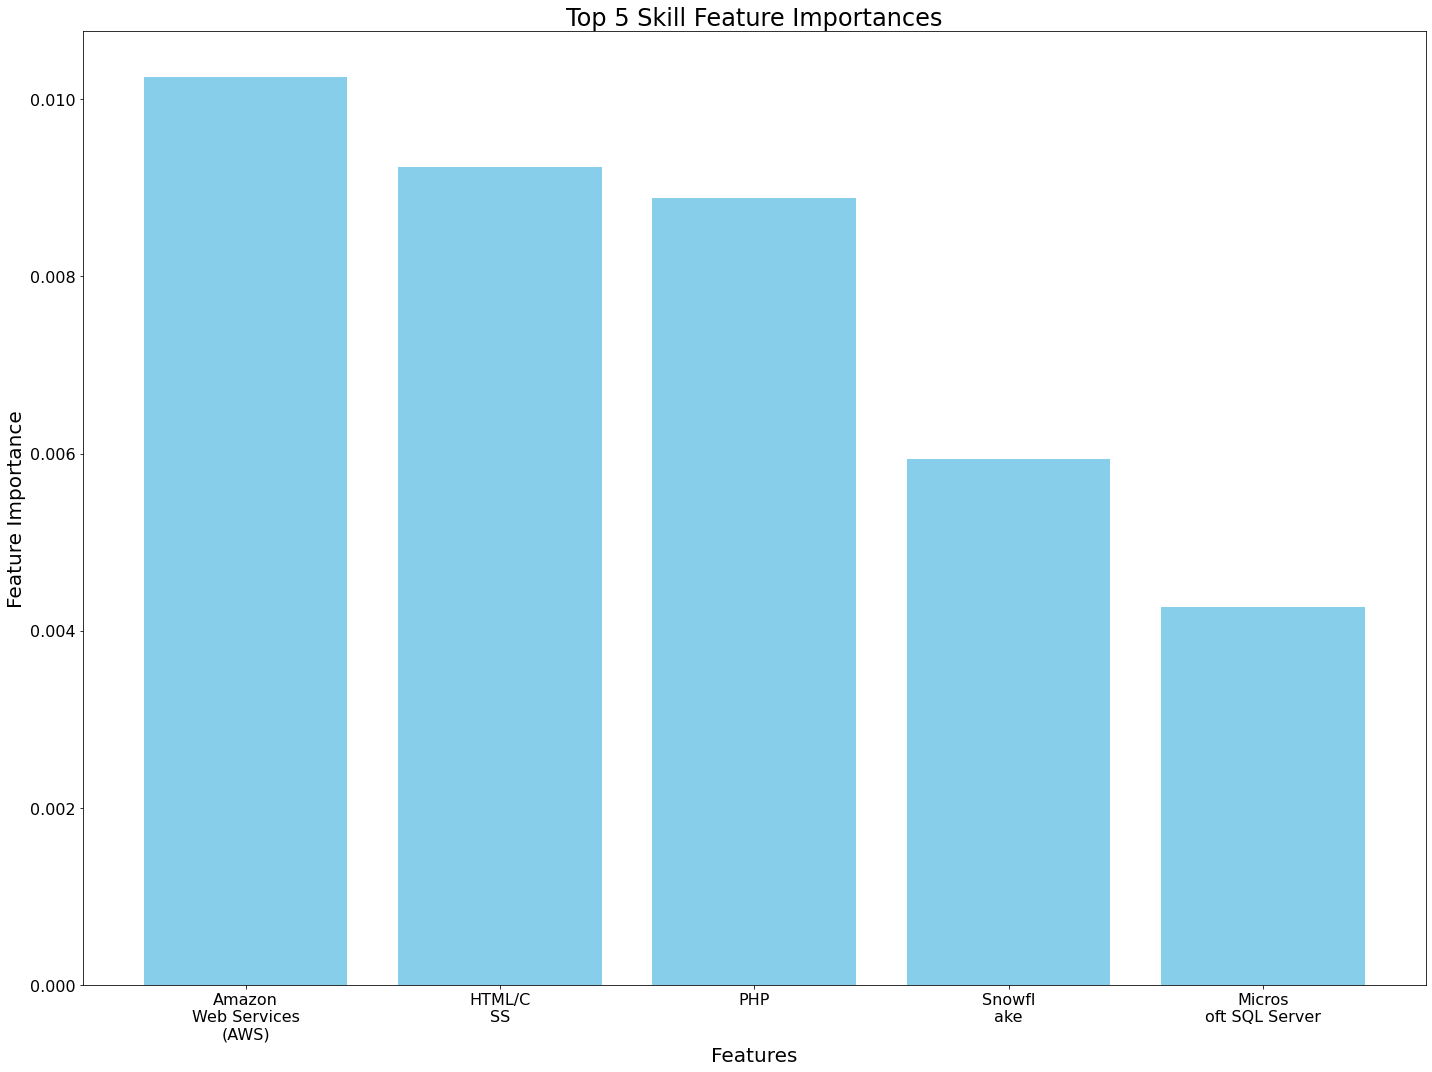

In [34]:
# 1 What skills are the most important?

skill_columns = pd.Series(skill_columns)
skill_columns.name = 'feature'

skill_features = pd.merge(skill_columns, feature_importance, how = 'left')

plot_feature_importance(
    feature_df=skill_features,
    top_n=5,
    title="Top 5 Skill Feature Importances"
)

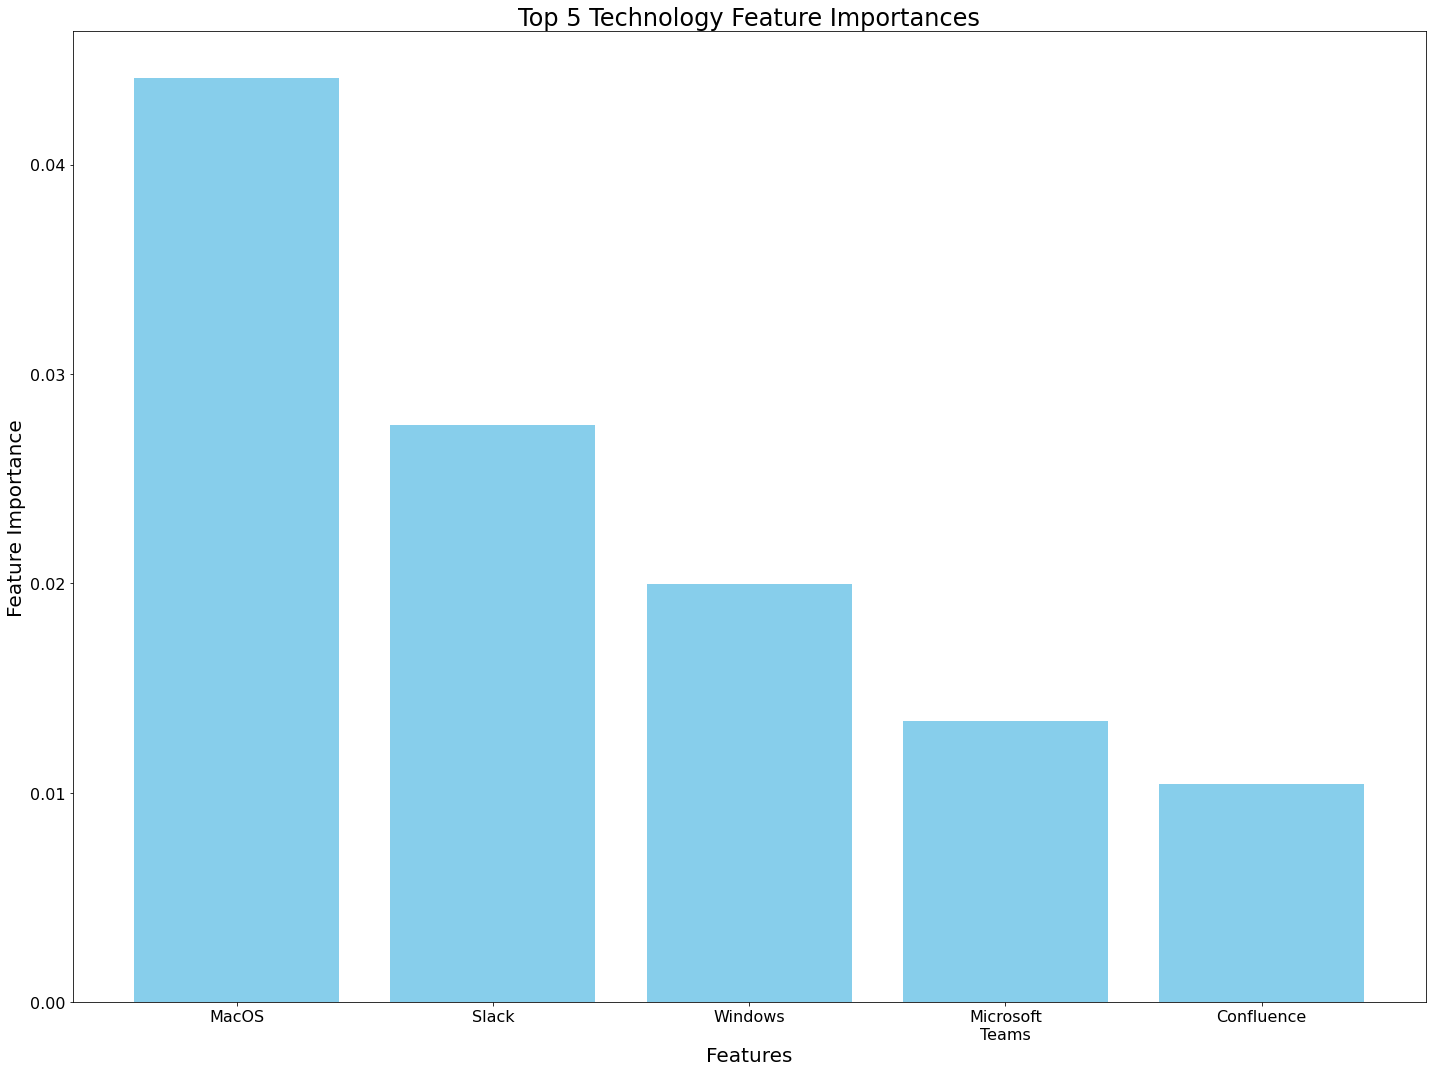

In [35]:

# 2 What technologies are the most important?

tech_columns = pd.Series(tech_columns)
tech_columns.name = 'feature'

tech_features = pd.merge(tech_columns, feature_importance, how = 'left')

plot_feature_importance(
    feature_df=tech_features,
    top_n=5,
    title="Top 5 Technology Feature Importances"
)

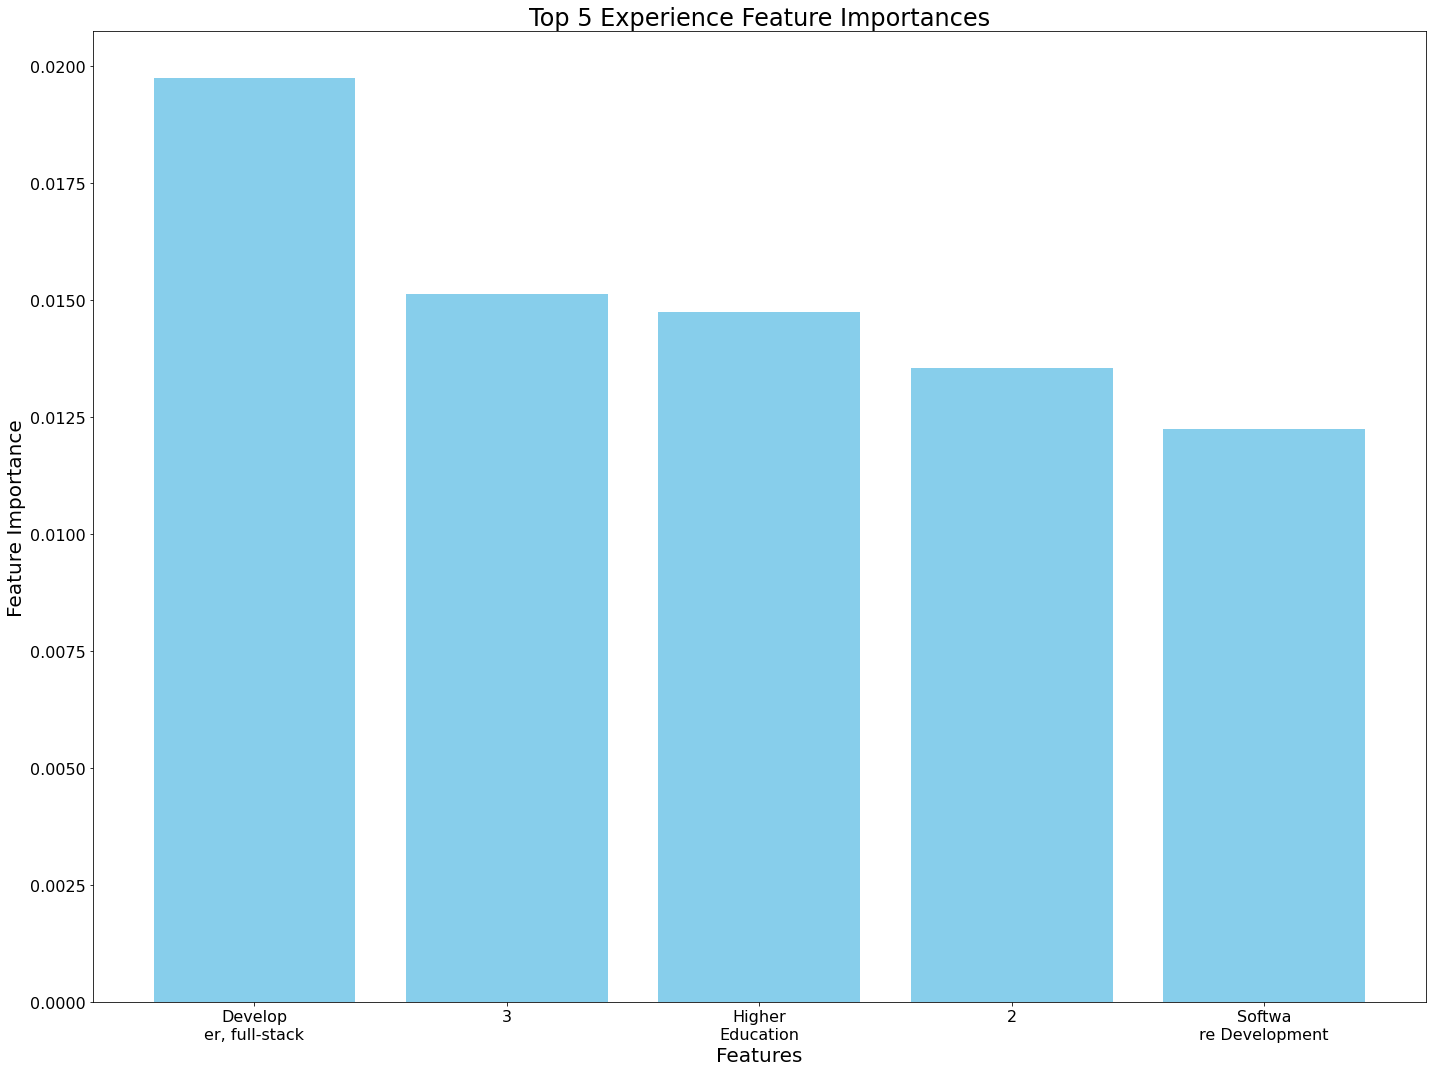

In [36]:
# 3 How important is experience level?

experience_columns = pd.Series(experience_columns)
experience_columns.name = 'feature'

experience_features = pd.merge(experience_columns, feature_importance, how = 'left')

plot_feature_importance(
    feature_df=experience_features,
    top_n=5,
    title="Top 5 Experience Feature Importances"
)